<a href="https://colab.research.google.com/github/yaPhilya/nlp_course/blob/master/week8_multitask/seminar_from_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Seminar: Named EntityRecognition

Today we're gonna solve the problem of named entity recognition. Here's what it does in one picture:
![img](https://commons.bmstu.wiki/images/0/00/NER1.png)
[image source](https://bit.ly/2Pmg7L2)


For each word, in a sentence, your model should predict a named entity class:


In [0]:
import numpy as np
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

### Data
Our model will train on a [Groningen Meaning Bank corpus](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus).

Each word of every sentence is labelled with named entity class and a part-of-speech tag.

The named entity classes include:
* __B-LOC__ - location - first token
* __I-LOC__ - location - subsequent tokens
* __B-ORG__ - organization - first token
* __O__ - not a named entity

Take a look for yourself:

In [0]:
!wget https://www.dropbox.com/s/xobyz6jgovvz3dm/kaggle-train.conll?dl=1 -O kaggle-train.conll

--2018-11-08 17:19:55--  https://www.dropbox.com/s/xobyz6jgovvz3dm/kaggle-train.conll?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/xobyz6jgovvz3dm/kaggle-train.conll [following]
--2018-11-08 17:19:55--  https://www.dropbox.com/s/dl/xobyz6jgovvz3dm/kaggle-train.conll
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2b72b412744b76509f7b0219d7.dl.dropboxusercontent.com/cd/0/get/AVFZ2yH5IoW58wYsmOfB_JJUAADbZD3IEfbwMU1gEWV9IMPGbYy9uo8z2XjUw_emlPcGT1ptWxhcVbzTj8QqJxsEo6aZVdnio7Wlgon1NufNVBR2NrtgEz3sUBk16pF4vhG8blie7PkIIjewxMFiON3kKy6jw3yEubnkqWMuDKNQKGSjarxkBydSCK30F7JugT0/file?dl=1 [following]
--2018-11-08 17:19:55--  https://uc2b72b412744b76509f7b0219d7.dl.dropboxusercontent.com/cd/0/get/AVFZ2yH5IoW58wYsmOfB_JJUAADbZD3

In [0]:
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/week8_multitask/utils.py -O utils.py

--2018-11-08 17:20:08--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/week8_multitask/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6853 (6.7K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   6.69K  --.-KB/s    in 0s      

2018-11-08 17:20:08 (70.6 MB/s) - ‘utils.py’ saved [6853/6853]



In [0]:
from utils import read_conll
data = read_conll('./kaggle-train.conll', lower_words=True)

data[333]

{'ne': 'O O O O O O B-ORG I-ORG O O O B-LOC O B-LOC O B-LOC I-LOC O B-LOC O B-LOC O B-LOC O B-LOC O B-LOC O B-LOC O B-LOC O B-LOC O B-LOC O B-LOC O B-LOC O B-LOC O B-LOC O B-LOC O',
 'pos': 'DT CD NNS RB JJ IN NNP NNP NN NN VBP NNP , NNP , NNP NNP , NNP , NNP , NNP , NNP , NNP , NNP , NNP , NNP , NNP , NNP , NNP , NNP , NNP CC NNP .',
 'word': 'the 17 countries now eligible for world bank debt relief are benin , bolivia , burkina faso , ethiopia , ghana , guyana , honduras , madagascar , mali , mozambique , nicaragua , niger , rwanda , senegal , tanzania , uganda and zambia .'}

In [0]:
from sklearn.model_selection import train_test_split
train_data, dev_data = train_test_split(data, test_size=0.25, random_state=42)
print("train: {}, test: {}".format(len(train_data), len(dev_data)))

train: 35967, test: 11989


In [0]:
from utils import Vocab
vocabs = {
    key: Vocab.from_lines([row[key] for row in train_data])
    for key in ['word', 'pos', 'ne']
}

def prepare_batch(data):
    keys = data[0].keys()
    return {
        key: vocabs[key].to_matrix(row[key] for row in data)
        for key in keys
    }

In [0]:
dummy_rows = sorted(data, key=lambda row: len(row['word']))[100:102]
print(dummy_rows[0])
print(dummy_rows[1])
prepare_batch(dummy_rows)

{'word': 'well , it could happen !', 'pos': 'RB , PRP MD VB .', 'ne': 'O O O O O O'}
{'word': 'sudan denies the claim .', 'pos': 'NNP VBZ DT NN .', 'ne': 'B-LOC O O O O'}


{'ne': array([[10, 10, 10, 10, 10, 10],
        [ 2, 10, 10, 10, 10,  0]], dtype=int32),
 'pos': array([[26,  4, 24, 17, 33,  5],
        [19, 38, 10, 18,  5,  0]], dtype=int32),
 'word': array([[27512,   289, 13824,  7061, 12084,     2],
        [24626,  7884, 25433,  6090,   292,     0]], dtype=int32)}

# Baseline: single-task model

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/gorynich_ne.png)

Let's start with a straightforward model that does named entity recognition.


The image will make sense later :)

In [0]:
import keras, keras.layers as L

Using TensorFlow backend.


In [0]:
import keras, keras.layers as L

class SimpleModel:
    def __init__(self, name, emb_size=128, hid_size=128):
        """ 
        A model that predicts named entity class for each word
        We recommend the following model:
        * Embedding
        * Bi-directional LSTM
        * Linear layer to predict logits
        """
        
        # define layers
        self.emb = L.Embedding(len(vocabs['word']), emb_size)
        self.lstm = L.Bidirectional(L.LSTM(hid_size // 2, return_sequences=True))
        self.logits = L.Dense(len(vocabs['ne']))
    
    def __call__(self, input_ix):
        """
        Compute logits for named entity recognition
        :param input_ix: a matrix of token indices, int32[batch_size, seq_length]
        """
        
        ner_logits = self.logits(self.lstm(self.emb(input_ix)))
        return {'ne': ner_logits}

In [0]:
model = SimpleModel('mod1')

dummy_ix = tf.constant(prepare_batch(train_data[:3])['word'])
dummy_out = model(dummy_ix)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_out['ne'])

assert dummy_logits.shape == (3, dummy_ix.shape[1], len(vocabs['ne']))
assert dummy_logits.min() < 0 and dummy_logits.max() > 0, "you ~may~ have added nonlinearity after logits."\
                                                          "Make sure they're just a linear layer"

In [0]:
from utils import infer_mask

class trainer:
    """ A bunch of tensorflow operations used for model training """
    
    ph = {
        'word': tf.placeholder('int32', [None, None], name='input_tokens'),
        'ne': tf.placeholder('int32', [None, None], name='named_entities'),
    }

    logits = model(ph['word'])
    mask = infer_mask(ph['word'])
    
    loss = -tf.nn.log_softmax(logits['ne'], -1) * tf.one_hot(ph['ne'], len(vocabs['ne']))
    loss = tf.reduce_sum(loss * mask[:, :, None]) / tf.reduce_sum(mask)

    step = tf.train.AdamOptimizer().minimize(loss)

### Training loop

Nothin' special: sample random batches and perform SGD steps

In [0]:
def iterate_minibatches(data, batch_size=128, shuffle=True, cycle=False, max_batches=None):
    indices = np.arange(len(data))
    total_batches = 0
    while True:
        if shuffle: indices = np.random.permutation(indices)
        for start_i in range(0, len(data), batch_size):
            batch_ix = indices[start_i: start_i + batch_size]
            yield prepare_batch(data[batch_ix])
            total_batches += 1
            if max_batches and total_batches >= max_batches:
                raise StopIteration()
        if not cycle: break
            

def compute_error_rate(trainer, data, batch_size=128, key='ne'):
    numerator = denominator = 0.0
    for batch in iterate_minibatches(data, batch_size, shuffle=False, cycle=False):
        batch_ne_logits, batch_mask = sess.run([trainer.logits[key], trainer.mask], 
                                               {trainer.ph['word']: batch['word']})
        numerator += np.sum((batch[key] == batch_ne_logits.argmax(-1)) * batch_mask)
        denominator += batch_mask.sum()
    return (1.0 - numerator / denominator) * 100

In [0]:
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
eval_every = 100

loss_history, dev_err_history = [], []
sess.run(tf.global_variables_initializer())

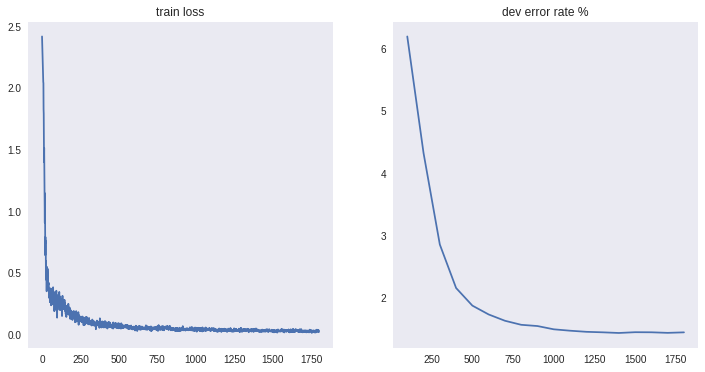

1827it [10:06,  4.11it/s]

KeyboardInterrupt: ignored

In [0]:
for batch in tqdm(iterate_minibatches(train_data, cycle=True, max_batches=2500)):
    loss_t, _ = sess.run([trainer.loss, trainer.step],
                         {trainer.ph[key]: batch[key] for key in trainer.ph})
    loss_history.append(loss_t)
    
    if len(loss_history) % eval_every == 0:
        err_t = compute_error_rate(trainer, dev_data)
        dev_err_history.append(err_t)

        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('train loss'), plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(1, len(dev_err_history) + 1) * eval_every, dev_err_history)
        plt.title('dev error rate %'), plt.grid()
        plt.show()

In [0]:
print("Best dev error rate = %.3f%%" % min(dev_err_history))
assert min(dev_err_history) < 1.5, "you can do better!"

# Multitask model: NER + POS

Our data contains not only named entity labels, but also part-of-speech tags. Those problems are similar in nature, making it a good candidate for multi-tasking. With any luck, ouyr model will become better at named entity recognition by learning for POS-tagging.

![model2](https://github.com/yandexdataschool/nlp_course/raw/master/resources/gorynich_2.png)

In [0]:
import keras, keras.layers as L

class MultitaskModel:
    def __init__(self, name, emb_size=128, hid_size=128):
        """ 
        Equivalent to the SimpleModel above, but with two 
        linear "heads": one for "ne" logits and another for "pos".
        Both heads should grow from the same intermediate "body" layer
        """
        # define layers:
        self.emb = L.Embedding(len(vocabs['word']), emb_size)
        self.lstm = L.Bidirectional(L.CuDNNLSTM(hid_size // 2, return_sequences=True))
        self.logits_ne = L.Dense(len(vocabs['ne']))
        self.logits_pos = L.Dense(len(vocabs['pos']))
    
    def __call__(self, input_ix):
        """
        Compute logits for named entity recognition
        """
        
        ner_logits = self.logits_ne(self.lstm(self.emb(input_ix)))
        pos_logits = self.logits_pos(self.lstm(self.emb(input_ix)))
        return {'ne': ner_logits, 'pos': pos_logits}

In [0]:
model = MultitaskModel('mod2')

dummy_ix = tf.constant(prepare_batch(train_data[:3])['word'])
dummy_out = model(dummy_ix)
assert 'ne' in dummy_out and 'pos' in dummy_out

sess.run(tf.global_variables_initializer())

for key, logits in sess.run(dummy_out).items():
    assert logits.shape == (3, dummy_ix.shape[1], len(vocabs[key]))

In [0]:
from utils import infer_mask

class multitask_trainer:
    """ A trainer that computes losses for both NER and POS tasks and adds them together. """    
    ph = {
        'word': tf.placeholder('int32', [None, None], name='input_tokens'),
        'ne': tf.placeholder('int32', [None, None], name='named_entities'),
        'pos': tf.placeholder('int32', [None, None], name='part_of_speech_tags'),
    }

    logits = model(ph['word'])
    mask = infer_mask(ph['word'])
    
    # Compute loss for NER. Feel free to reuse the code from original trainer

    ner_loss = -tf.nn.log_softmax(logits['ne'], -1) * tf.one_hot(ph['ne'], len(vocabs['ne']))
    ner_loss = tf.reduce_sum(ner_loss * mask[:, :, None]) / tf.reduce_sum(mask)

    # Compute the same kind of loss for POS.  (key: 'pos')

    pos_loss = -tf.nn.log_softmax(logits['pos'], -1) * tf.one_hot(ph['pos'], len(vocabs['pos']))
    pos_loss = tf.reduce_sum(pos_loss * mask[:, :, None]) / tf.reduce_sum(mask)
    
    # The total loss is just a sum of two losses.
    # Note: you can use weighted combination of losses to squeeze a few more %%
    loss = ner_loss + pos_loss
    
    step = tf.train.AdamOptimizer().minimize(loss)

In [0]:
dummy_batch = prepare_batch(train_data[:3])
ner_loss, pos_loss = sess.run([multitask_trainer.ner_loss, multitask_trainer.pos_loss], 
                              {multitask_trainer.ph[key]: dummy_batch[key] for key in multitask_trainer.ph})

assert ner_loss > 0 and np.shape(ner_loss) == (), "loss must be a positive scalar"
assert pos_loss > 0 and np.shape(pos_loss) == (), "loss must be a positive scalar"

In [0]:
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

loss_history, dev_err_history = [], []
sess.run(tf.global_variables_initializer())

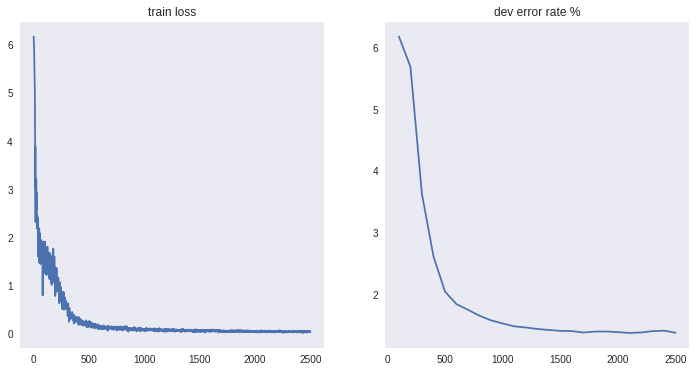


2500it [03:16, 12.70it/s]

In [0]:
for batch in tqdm(iterate_minibatches(train_data, cycle=True, max_batches=2500)):
    loss_t, _ = sess.run([multitask_trainer.loss, multitask_trainer.step], 
                         {multitask_trainer.ph[key]: batch[key] for key in multitask_trainer.ph})
    loss_history.append(loss_t)
    
    if len(loss_history) % 100 == 0:
        err_t = compute_error_rate(multitask_trainer, dev_data)
        dev_err_history.append(err_t)

        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('train loss'), plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(1, len(dev_err_history) + 1) * 100, dev_err_history)
        plt.title('dev error rate %'), plt.grid()
        plt.show()

In [0]:
print("Best dev error rate = %.3f%%" % min(dev_err_history))
assert min(dev_err_history) < 1.4, "you can do better!"

Best dev error rate = 1.369%


### Final evaluation

Let's now evaluate our corpora on a small expert-labeled dataset.

In [0]:
!wget https://www.dropbox.com/s/nfq7kp97ox7mwtz/wnut-test.conll?dl=1 -O wnut-test.conll 2> log
    
test_data = read_conll("./wnut-test.conll", ['word', 'ne'])
compute_error_rate(multitask_trainer, test_data)

## The real Zmey Gorynich [bonus section] 

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/gorynich_small.png)

Two heads are great, but three's even better! Let's add language modeling to the task.

With language models, however, there are a few complications:
* Our data is too small for LM training. Let's use [1 billion word benchmark](http://www.statmt.org/lm-benchmark/) instead. It *may* even be a good idea to preserve cases.
* Language models have some issues with being bidirectional. We recommend training forward and backward models separately and fusing them together. Or use the same approach as [ELMO](https://tfhub.dev/google/elmo/2).
* The simplest scheme is to pre-train as a language model and fine-tune for NER and POS. We recommend starting from that.

It is also a good idea to try structured [CRF loss](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/crf) for NER/POS.